 # 第一题代码
## 第二问

In [159]:
#引入依赖
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install statsmodels
!pip install seaborn

import numpy
import scipy.stats
import scipy.optimize
import scipy.special
import math
import seaborn
import matplotlib.pyplot as plt
import pandas
import pylab
import pickle

首先进行初始化和读入数据

In [160]:
with open ("btc_hw4_lda_data.p", "rb") as handle :
  data_loaded = pickle.load (handle)

beta=data_loaded['beta_matrix'].T
w=data_loaded['data']

#Basic Constant
K = 4
M = 100
N = 200
alpha = 0.1

#要求的矩阵参数随机初始化，使用标准正态
#gamma = numpy.abs(numpy.random.normal(size=[M,K], loc=0 ,scale =1))+0.1
gamma = numpy.zeros([M,K])+0.1
#phi = numpy.abs(numpy.random.normal(size = [M,N,K], loc = 0, scale = 1))+0.1
phi = numpy.zeros([M,N,K])+0.1# print(beta)
# print(data)


具体算法见手写pdf,这里我们指出，直接通过个体ELBO的收敛性而不是全部ELBO的收敛性（因为我们只对第一个个体进行LDA推断）来实行停止条件。

另外需要格外注意，我们的“文档”已经经过排序与单词表排列相同，所以我们不用indicator而是直接用w乘对应的beta。

In [161]:
#首先定义个体ELBO的计算，m是个体编号


def ELBO(m, K,M,N,alpha,beta, w, gamma, phi):
    gamma_m_hat = numpy.sum(gamma[m-1,])
    w_full = numpy.nonzero(w[m-1,])
    temp = 0
    temp1 = 0
    temp2 = 0
    for n in range(N):
        temp += numpy.sum(phi[m-1, n,]*(scipy.special.digamma(gamma[m-1,])-scipy.special.digamma(gamma_m_hat)))
        temp1 += numpy.sum(phi[m-1, n,]*(w[m-1,n] * numpy.log(beta[:, n])))
        temp2 += numpy.sum(phi[m-1, n ,]*numpy.log(phi[m-1, n ,]))
    positive_term = (alpha-1)*(numpy.sum(scipy.special.digamma(gamma[m-1,]))-scipy.special.digamma(gamma_m_hat)*K)+ temp + temp1
    temp3 = -numpy.sum(numpy.log(scipy.special.gamma(gamma[m-1,]))) + math.lgamma(numpy.sum(gamma[m-1,]))
    #print(f'here is {numpy.log(scipy.special.gamma(numpy.sum(gamma[m-1,])))}')
    negative_term = numpy.sum((scipy.special.digamma(gamma[m-1,])  - scipy.special.digamma(gamma_m_hat))*(gamma[m-1,]-1))+temp2 + temp3
    return positive_term-negative_term

#数组在python中以地址传递
def updata_gamma(m, K,M,N,alpha,beta, w, gamma, phi):
    gamma[m-1, ] = alpha + numpy.sum(phi[m-1,:,:],axis=0)

def updata_phi(m, K,M,N,alpha,beta, w, gamma, phi):
    for n in range(N):
        for k in range(K):
            phi[m-1,n,k] = numpy.exp((scipy.special.digamma(gamma[m-1,k]) - scipy.special.digamma(numpy.sum(gamma[m-1,]))))*(beta[k,n]**w[m-1,n])
        phi[m-1,n,] = phi[m-1,n,]/numpy.sum(phi[m-1,n,])

现在写主算法。

In [162]:
iteration_count = numpy.zeros(M)
ELBO_old = ELBO(1, K,M,N,alpha, beta, w, gamma, phi)
count = 0
while(True):
    updata_gamma(1, K,M,N,alpha,beta, w, gamma, phi)
    updata_phi(1, K,M,N,alpha,beta, w, gamma, phi)
    ELBO_new = ELBO(1, K,M,N,alpha, beta, w, gamma, phi)
    count += 1
    if ELBO_new - ELBO_old <= 0.001:
        print(ELBO_new - ELBO_old)
        iteration_count[0] = count
        break
    else:
        print(ELBO_new - ELBO_old)
    ELBO_old = ELBO_new

print(ELBO_new)

160.200188781539
1.087603909934444
0.16267446094911975
0.12963239989881004
0.1036705281326249
0.08320336599024358
0.067011672168519
0.05415660196740646
0.04391381530695071
0.03572312178891934
0.029150088719802625
0.023856795077335846
0.019579548400088242
0.016111890666422823
0.013291618003506755
0.010990846770482676
0.009108393620181232
0.007563915537389221
0.006293390878795435
0.005245624307349317
0.004379535280008895
0.003662047718876238
0.0030664422155268767
0.0025710650476185037
0.00215831334998029
0.0018138345960210245
0.0015258929772699048
0.0012848661696125419
0.0010828442505044222
0.0009133090052273474
-500.0342302123074


*RMK*:算法一开始不收敛，发现是运算精度的问题！Gamma函数的指数级增长使误差爆炸，因此使用log-gamma(math库)处理这一问题。接下来我们画出这一个体的$\phi$.此时，我们需要针对它的基因库作图，忽略没有出现的基因点位。

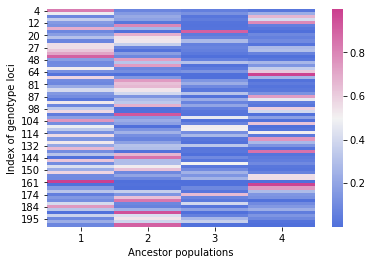

In [163]:
#首先取出我们需要的矩阵
index_individual_one, = numpy.nonzero(w[0,:])
phi_individual_one = numpy.zeros([len(index_individual_one),K])

for i in range(len(index_individual_one)):
    for k in range(K):
        phi_individual_one[i,k] = phi[0, index_individual_one[i],k]

#作图
phi_individual_one=pandas.DataFrame(phi_individual_one,index=index_individual_one,columns=numpy.array([1,2,3,4]))
%matplotlib inline
cmap = seaborn.diverging_palette(-100,700,sep=2,as_cmap=True)
seaborn.heatmap(phi_individual_one,cmap=cmap)
plt.xlabel('Ancestor populations')
plt.ylabel('Index of genotype loci')
plt.show()

## 第三问
和第二问没有本质区别，只不过是对$\gamma$进行推断，而且是对每个个体进行推断。因此，我们直接写出代码：

In [164]:
#首先得到完全inference
for m in range(2,M+1):
    count = 0
    # print(m)
    ELBO_old = ELBO(m, K,M,N,alpha, beta, w, gamma, phi)
    while(True):
        updata_gamma(m, K,M,N,alpha,beta, w, gamma, phi)
        updata_phi(m, K,M,N,alpha,beta, w, gamma, phi)
        count += 1
        ELBO_new = ELBO(m, K,M,N,alpha, beta, w, gamma, phi)
        if ELBO_new - ELBO_old <= 0.001:
            iteration_count[m-1] = count
            # print(ELBO_new - ELBO_old)
            break
        # else:
            # print(ELBO_new - ELBO_old)
        ELBO_old = ELBO_new

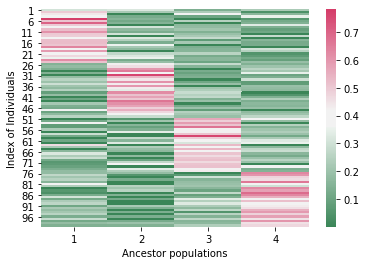

In [175]:
#得到ancestor类别推断矩阵
big_theta = numpy.zeros([M,K])
for i in range(M):
    big_theta[i,] = gamma[i,]/numpy.sum(gamma[i,])

#作图
big_theta=pandas.DataFrame(big_theta,index=range(1,M+1),columns=numpy.array([1,2,3,4]))
%matplotlib inline
cmap = seaborn.diverging_palette(500,0,sep=20,as_cmap=True)
seaborn.heatmap(big_theta,cmap=cmap)
plt.xlabel('Ancestor populations')
plt.ylabel('Index of Individuals')
plt.show()

## 第四问
我们依次排列所需的迭代次数，终止条件与题目中所说相同。

In [180]:
print(f'平均迭代{numpy.sum(iteration_count)/M}次。')
for i in range(M):
    print(f'第{i+1}个个体的推断用了{iteration_count[i]}次迭代。')

平均迭代52.54次。
第1个个体的推断用了30.0次迭代。
第2个个体的推断用了63.0次迭代。
第3个个体的推断用了117.0次迭代。
第4个个体的推断用了43.0次迭代。
第5个个体的推断用了65.0次迭代。
第6个个体的推断用了35.0次迭代。
第7个个体的推断用了70.0次迭代。
第8个个体的推断用了128.0次迭代。
第9个个体的推断用了34.0次迭代。
第10个个体的推断用了46.0次迭代。
第11个个体的推断用了45.0次迭代。
第12个个体的推断用了42.0次迭代。
第13个个体的推断用了43.0次迭代。
第14个个体的推断用了89.0次迭代。
第15个个体的推断用了49.0次迭代。
第16个个体的推断用了42.0次迭代。
第17个个体的推断用了57.0次迭代。
第18个个体的推断用了59.0次迭代。
第19个个体的推断用了36.0次迭代。
第20个个体的推断用了31.0次迭代。
第21个个体的推断用了42.0次迭代。
第22个个体的推断用了46.0次迭代。
第23个个体的推断用了36.0次迭代。
第24个个体的推断用了48.0次迭代。
第25个个体的推断用了41.0次迭代。
第26个个体的推断用了32.0次迭代。
第27个个体的推断用了25.0次迭代。
第28个个体的推断用了62.0次迭代。
第29个个体的推断用了36.0次迭代。
第30个个体的推断用了39.0次迭代。
第31个个体的推断用了73.0次迭代。
第32个个体的推断用了33.0次迭代。
第33个个体的推断用了50.0次迭代。
第34个个体的推断用了44.0次迭代。
第35个个体的推断用了34.0次迭代。
第36个个体的推断用了68.0次迭代。
第37个个体的推断用了26.0次迭代。
第38个个体的推断用了22.0次迭代。
第39个个体的推断用了46.0次迭代。
第40个个体的推断用了47.0次迭代。
第41个个体的推断用了123.0次迭代。
第42个个体的推断用了45.0次迭代。
第43个个体的推断用了102.0次迭代。
第44个个体的推断用了70.0次迭代。
第45个个体的推断用了36.0次迭代。
第46个个体的推断用了32.0次迭代。
第47个个体的推断用了101.0次迭代。
第48个个体的推断用了37.0次迭代。
第49个个体的推断用了26.0次迭代。
第50个个体的推断用了1

## 第五问
对$\alpha = 0.01,1,10$重复进行实验，每次重新画推断矩阵$\Theta$,并比较平均迭代次数。

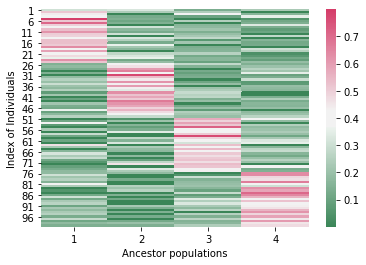

alpha= 0.01的平均迭代次数为52.2.
alpha= 1的平均迭代次数为32.12.
alpha= 10的平均迭代次数为13.56.


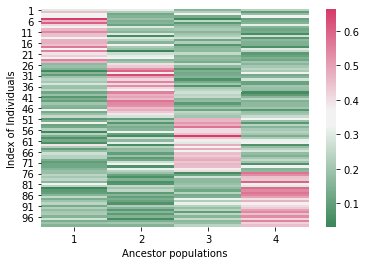

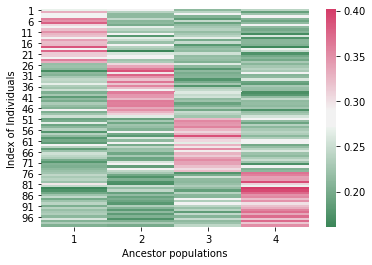

In [181]:
def repeated_experiment(alpha):
    K = 4
    M = 100
    N = 200

    #要求的矩阵参数随机初始化，使用标准正态
    #gamma = numpy.abs(numpy.random.normal(size=[M,K], loc=0 ,scale =1))+0.1
    gamma = numpy.zeros([M,K])+0.1
    #phi = numpy.abs(numpy.random.normal(size = [M,N,K], loc = 0, scale = 1))+0.1
    phi = numpy.zeros([M,N,K])+0.1#
    iteration_count = numpy.zeros(M)
    for m in range(1,M+1):
        count = 0
        # print(m)
        ELBO_old = ELBO(m, K,M,N,alpha, beta, w, gamma, phi)
        while(True):
            updata_gamma(m, K,M,N,alpha,beta, w, gamma, phi)
            updata_phi(m, K,M,N,alpha,beta, w, gamma, phi)
            count += 1
            ELBO_new = ELBO(m, K,M,N,alpha, beta, w, gamma, phi)
            if ELBO_new - ELBO_old <= 0.001:
                iteration_count[m-1] = count
                # print(ELBO_new - ELBO_old)
                break
            # else:
                # print(ELBO_new - ELBO_old)
            ELBO_old = ELBO_new

    big_theta = numpy.zeros([M,K])
    for i in range(M):
        big_theta[i,] = gamma[i,]/numpy.sum(gamma[i,])

    #作图
    big_theta=pandas.DataFrame(big_theta,index=range(1,M+1),columns=numpy.array([1,2,3,4]))
    %matplotlib inline
    cmap = seaborn.diverging_palette(500,0,sep=20,as_cmap=True)
    seaborn.heatmap(big_theta,cmap=cmap)
    plt.xlabel('Ancestor populations')
    plt.ylabel('Index of Individuals')
    plt.show()

    return numpy.sum(iteration_count)/M

print(f'alpha= 0.01的平均迭代次数为{repeated_experiment(0.01)}.')
print(f'alpha= 1的平均迭代次数为{repeated_experiment(1)}.')
print(f'alpha= 10的平均迭代次数为{repeated_experiment(10)}.')